[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv8 Instance Segmentation on a Custom Dataset

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wuZtUMEiKWY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is a popular version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the accompanying [blog post](https://blog.roboflow.com/how-to-train-yolov8-instance-segmentation/).

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- CLI Basics
- Inference with Pre-trained COCO Model
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Custom Model
- Inference with Custom Model
- Deploy the Trained Model to Roboflow

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Oct 24 18:39:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [10]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.4/112.6 GB disk)


In [11]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src=""
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a [supported format](https://roboflow.com/formats), the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 4: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLOv8` dataset format.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>




🟢 Tip: The examples below work even if you use our non-custom model. However, you won't be able to deploy it to Roboflow. To do that, create a custom dataset as described below or fork (copy) one into your workspace from Universe.

In [4]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow==1.1.48 --quiet

from roboflow import Roboflow

rf = Roboflow(api_key="y2xAGvz4lAm2KwMMuWsR")

project = rf.workspace("bracketbot").project("elevator-dbzwt")
version = project.version(1)
dataset = version.download("yolov8")


/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.3 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to elevator-1 in yolov8:: 100%|██████████| 142/142 [00:00<00:00, 5970.48it/s]


## Custom Training

In [5]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8n.yaml data={dataset.location}/data.yaml epochs=10 imgsz=640

/content
New https://pypi.org/project/ultralytics/8.3.73 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/datasets/elevator-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N

/content


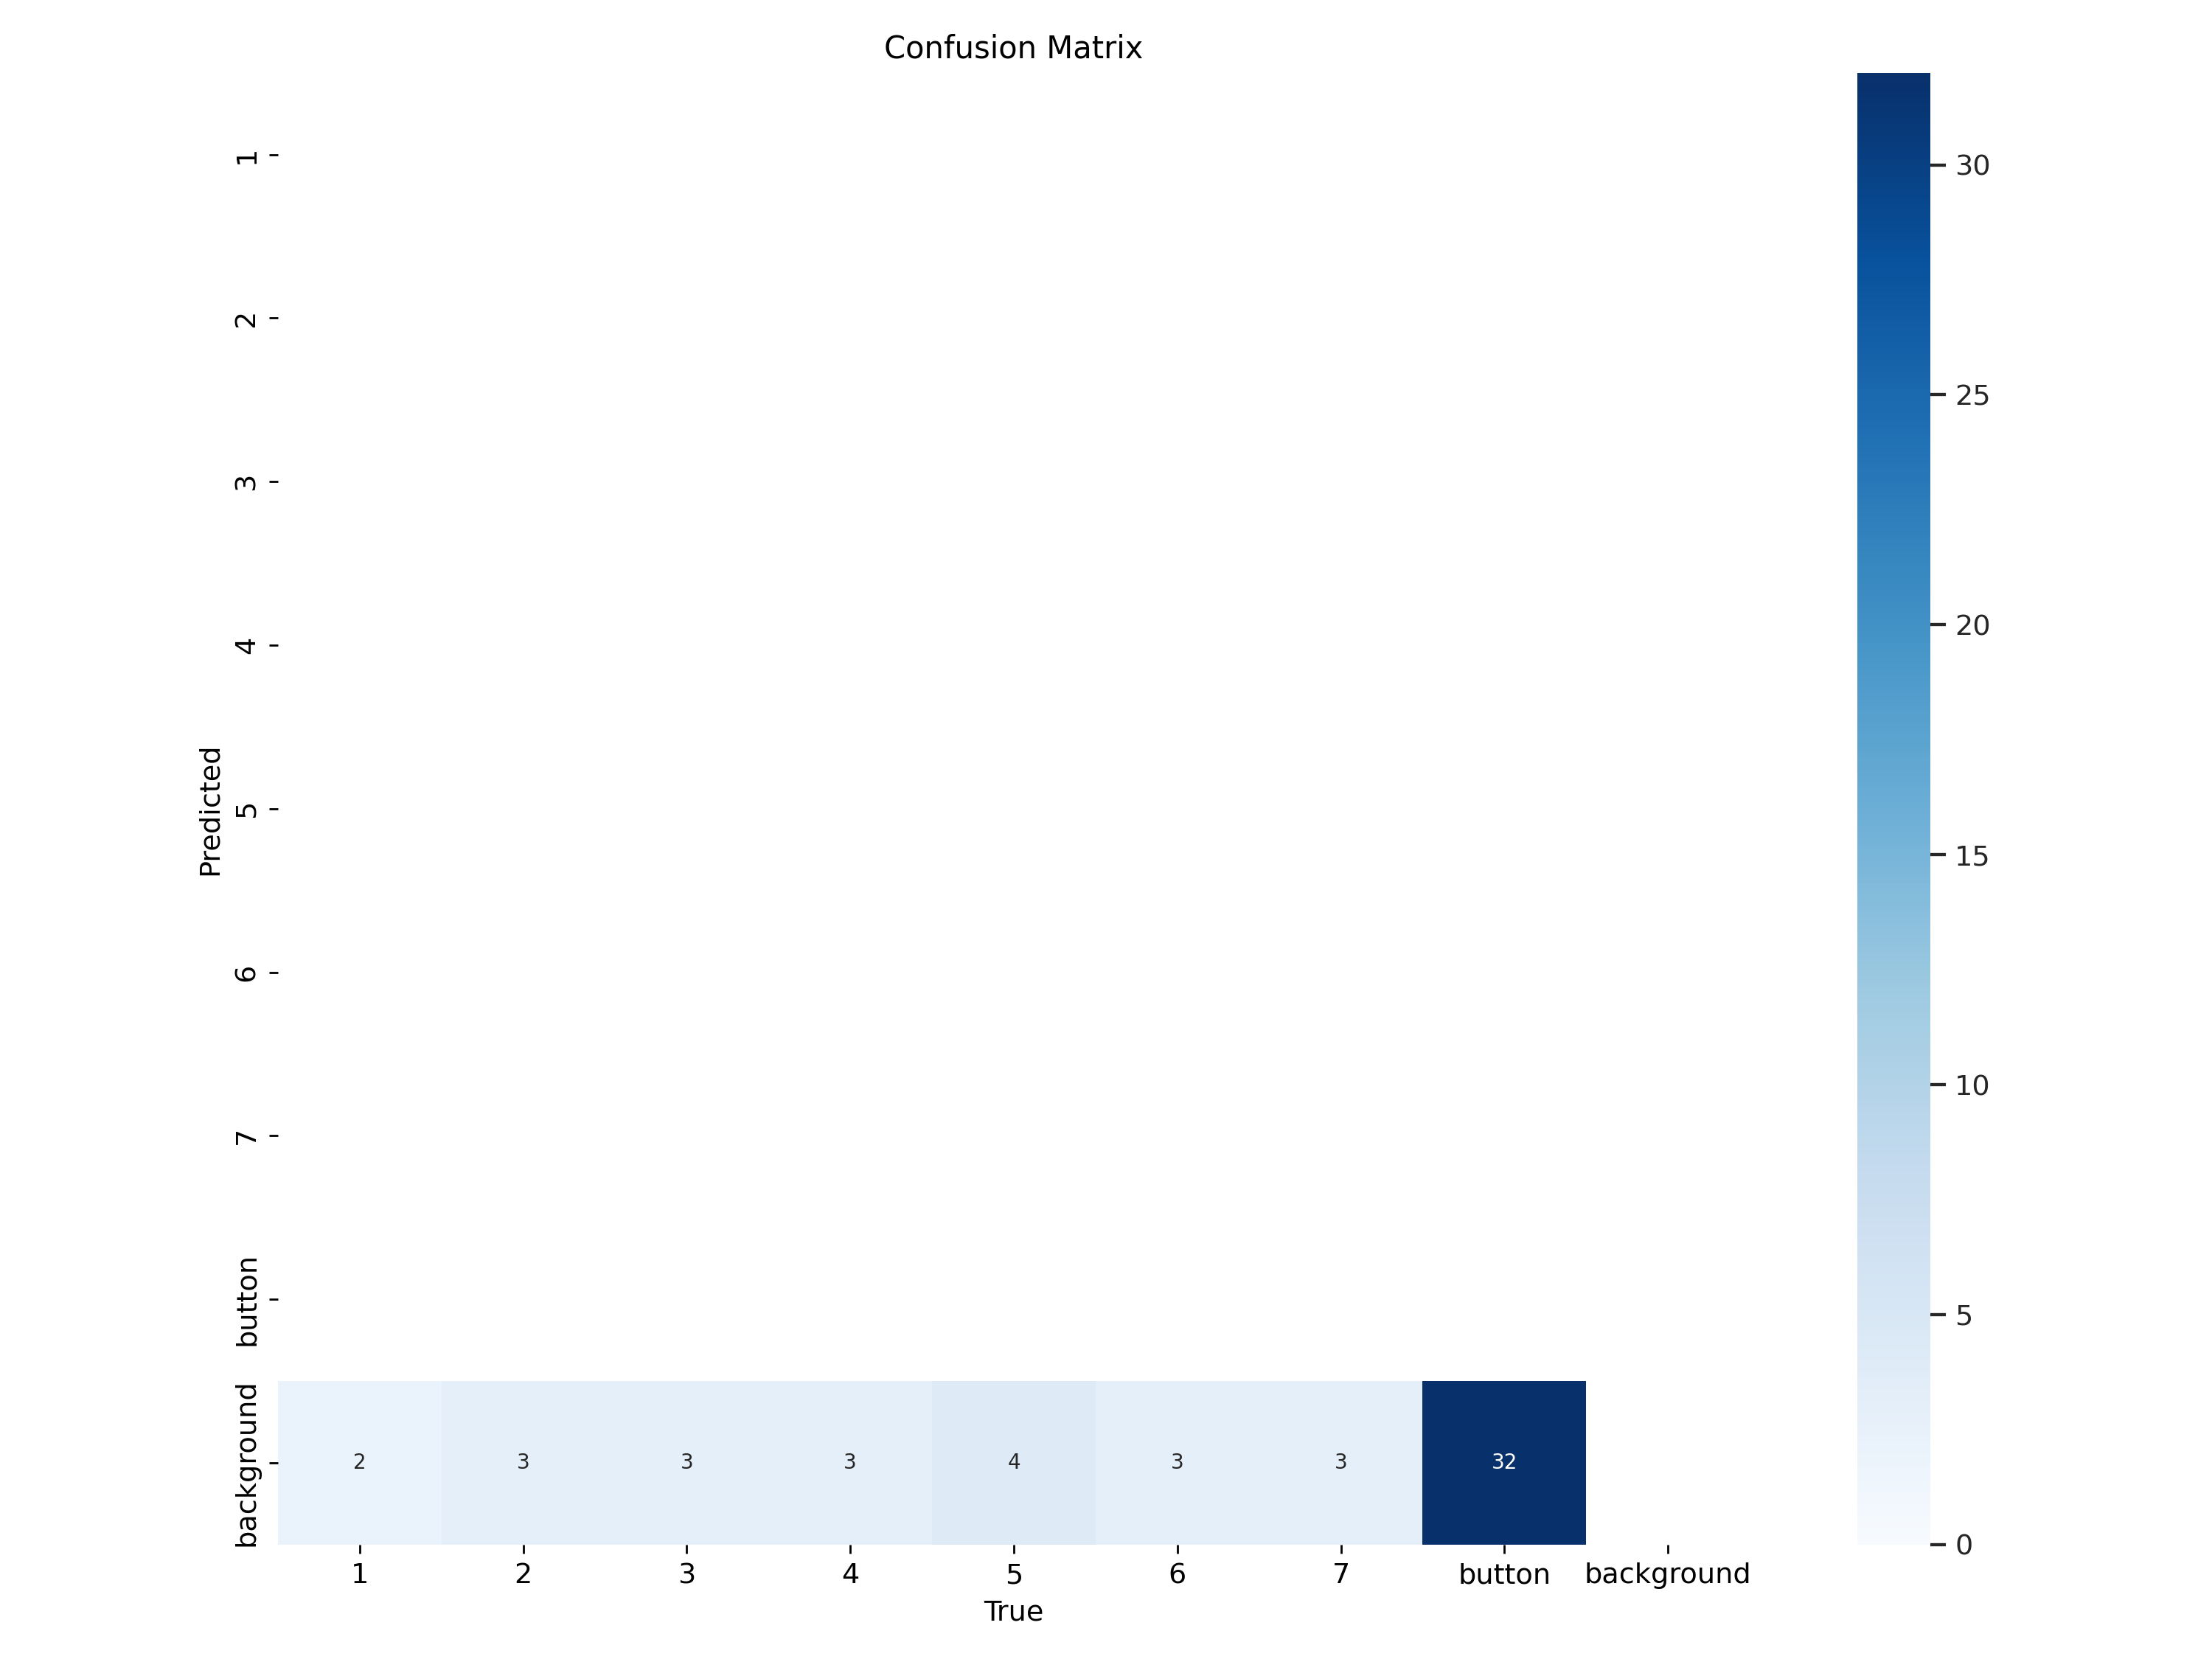

In [6]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


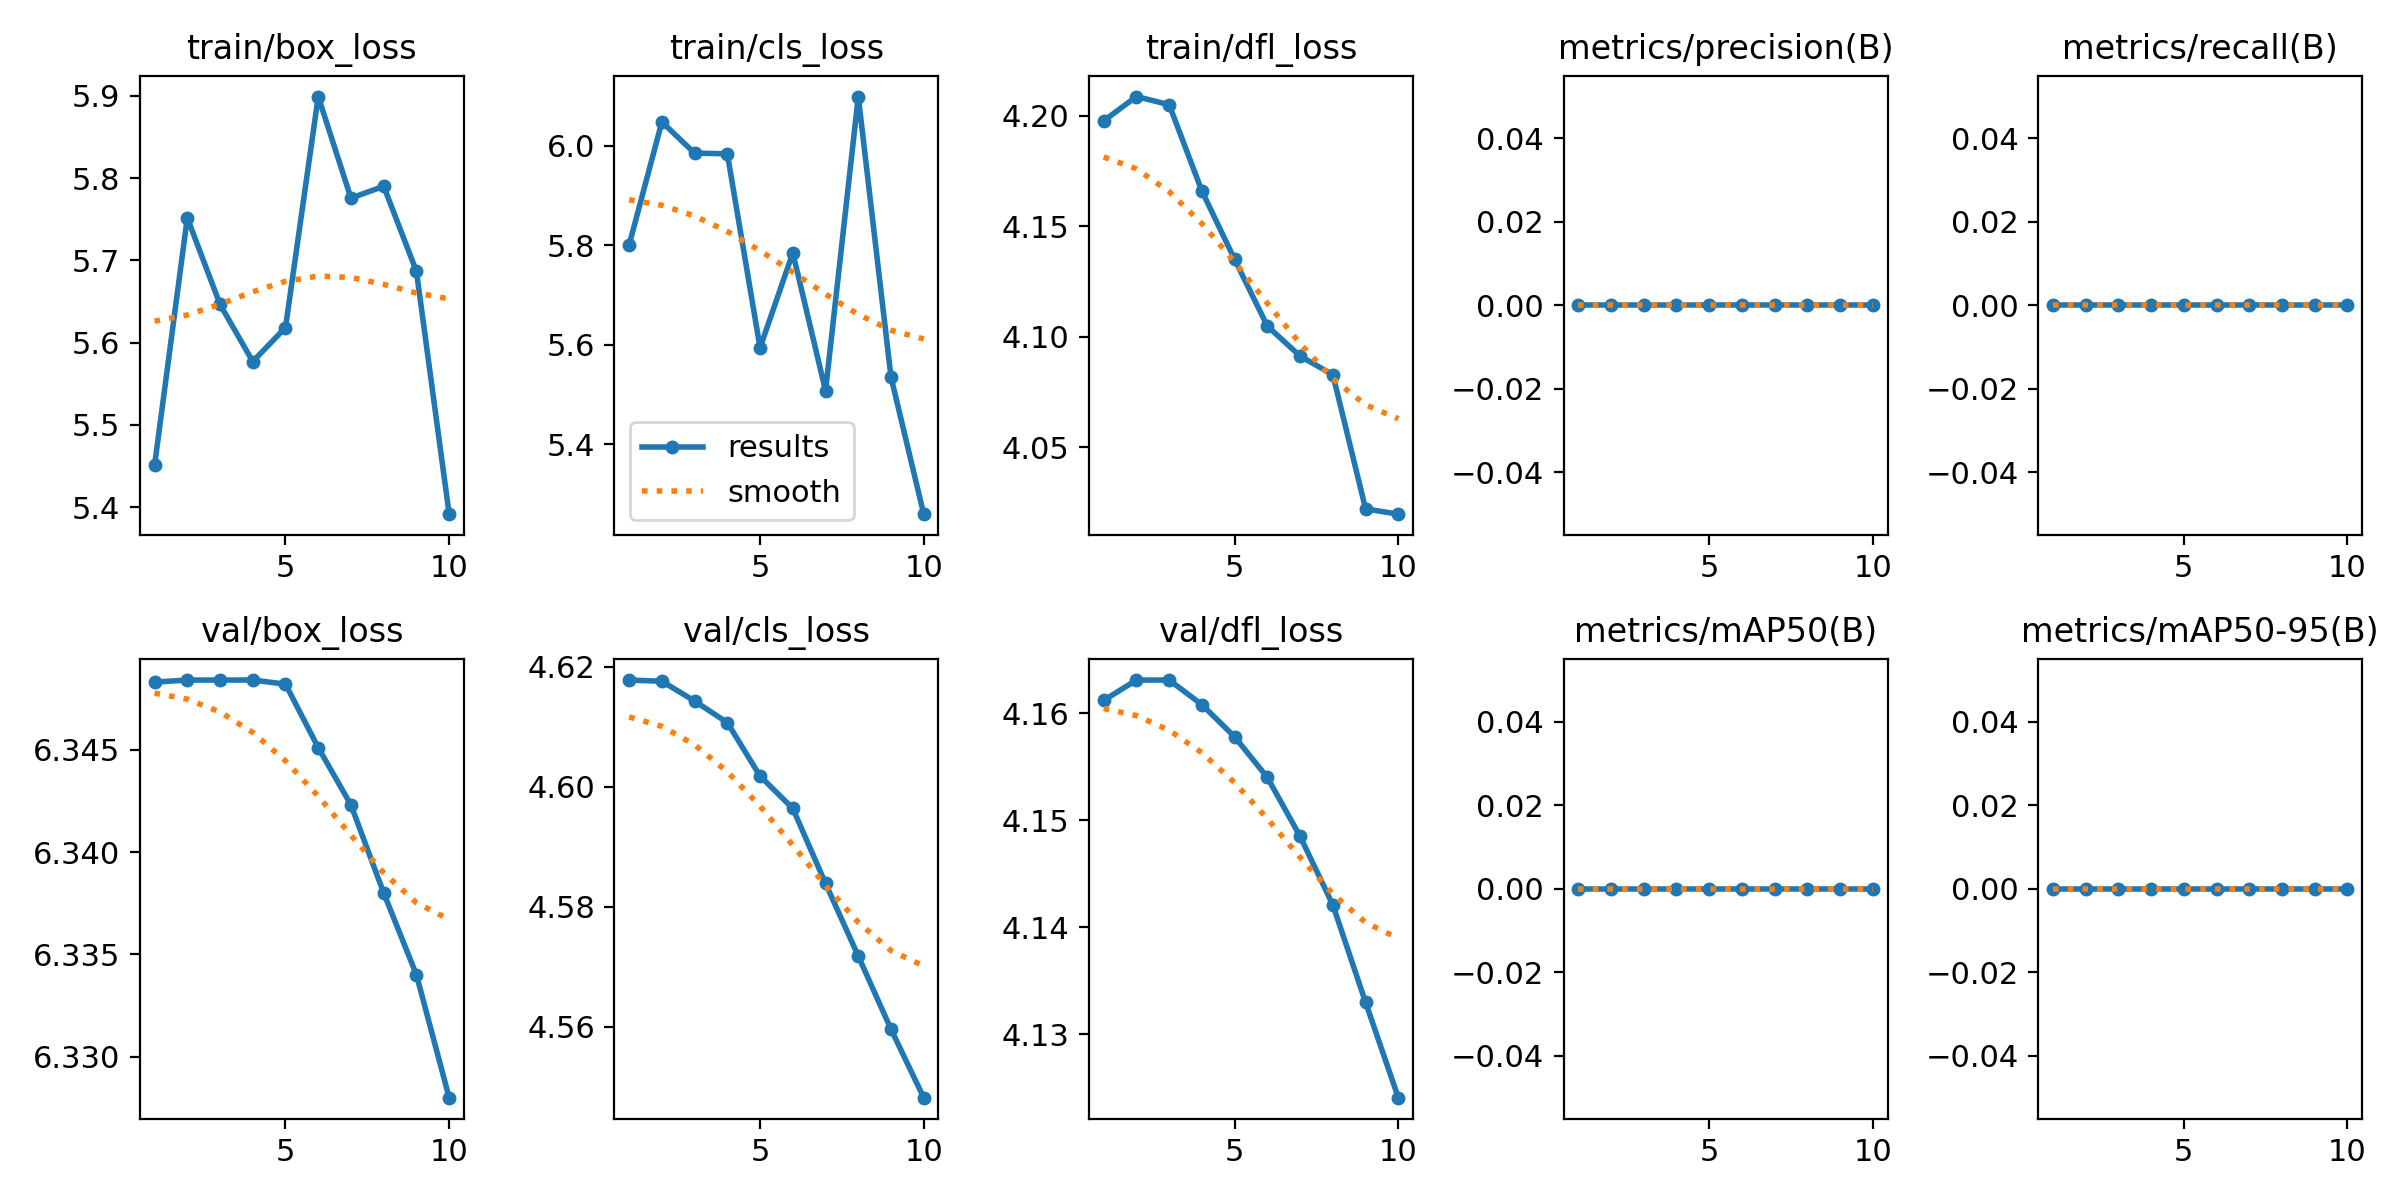

In [7]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


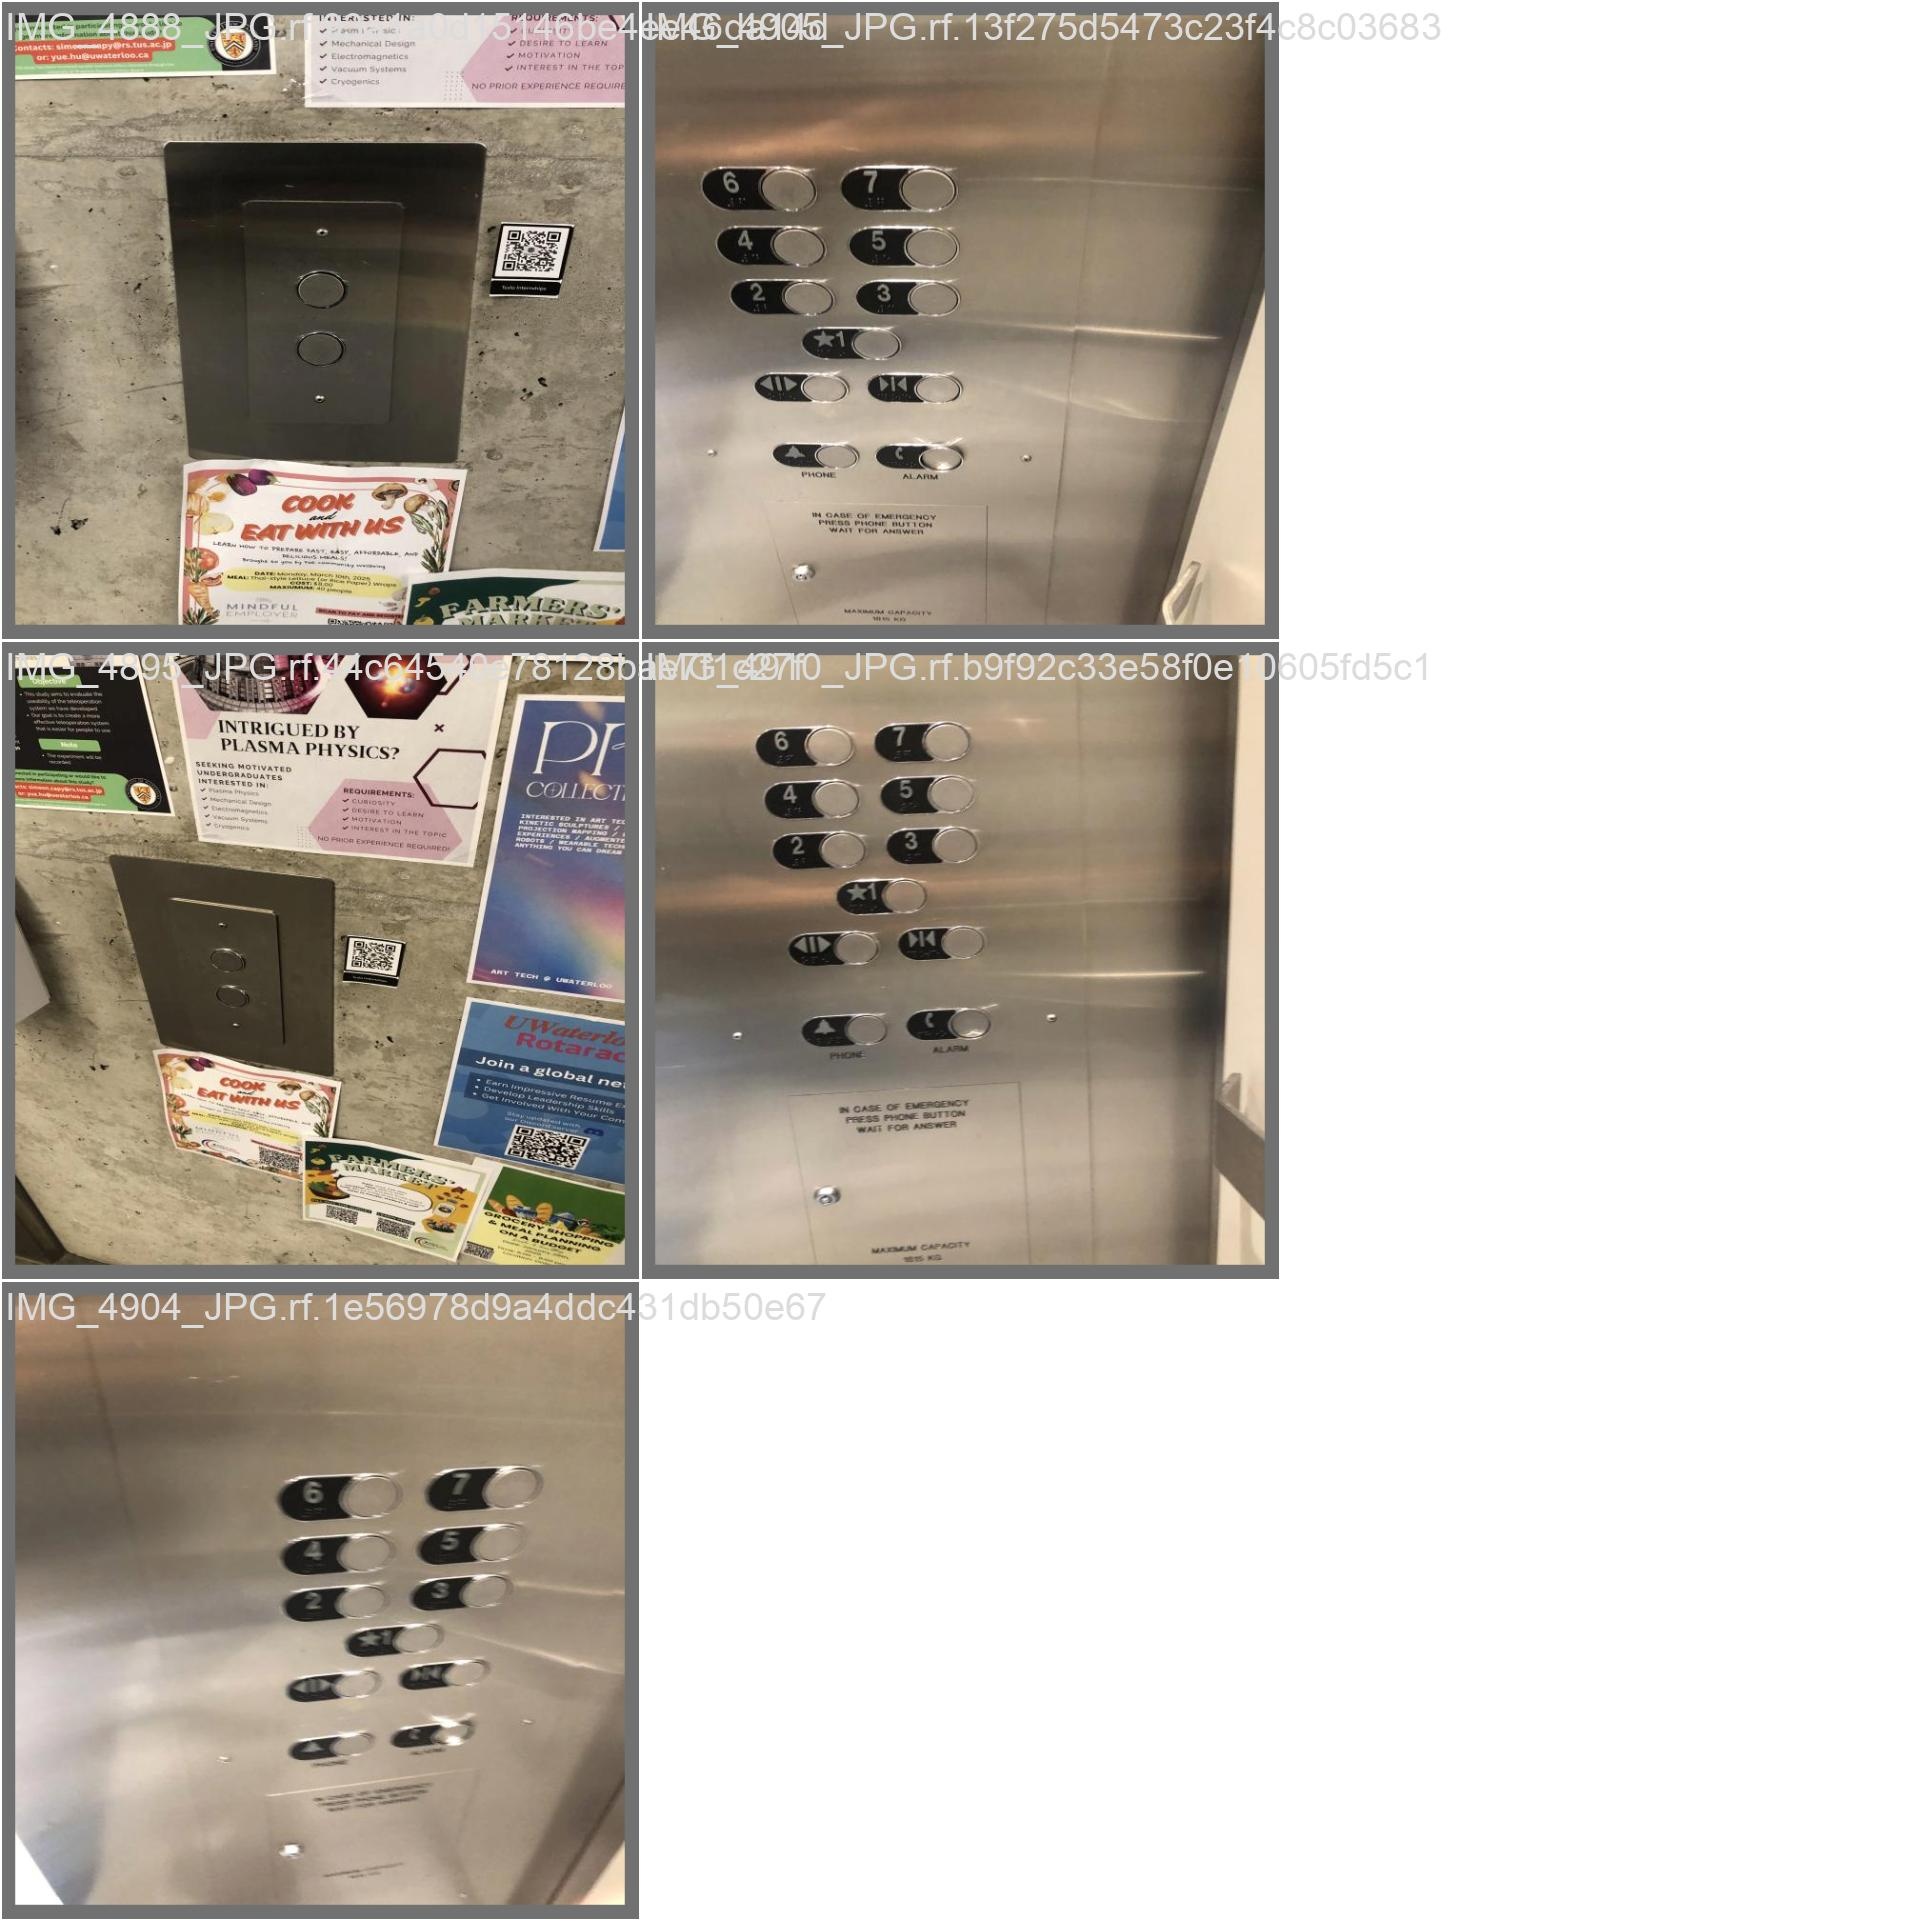

In [8]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [14]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/elevator-2/valid/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100% 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  2.24it/s]
                   all          5         53    0.00633      0.125      0.102     0.0785
                     1          2          2          0          0          0          0
                     2          3          3          0          0          0          0
                     3          3          3          0          0          0          0
                     4          3          3          0          0          0          0
                     5          3          4          0          0          0          0
                     6          3    

## Inference with Custom Model

In [16]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=true

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs

image 1/3 /content/datasets/elevator-2/test/images/IMG_4893_JPG.rf.84ed02700d1aebce9aba3c7b6a01d611.jpg: 640x640 (no detections), 9.0ms
image 2/3 /content/datasets/elevator-2/test/images/IMG_4906_JPG.rf.a9127208c628df0dfcf3855ac151c7f8.jpg: 640x640 (no detections), 7.4ms
image 3/3 /content/datasets/elevator-2/test/images/IMG_4913_JPG.rf.b21b234b8af0e392c01feabd1368b5bf.jpg: 640x640 (no detections), 7.4ms
Speed: 2.3ms preprocess, 7.9ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


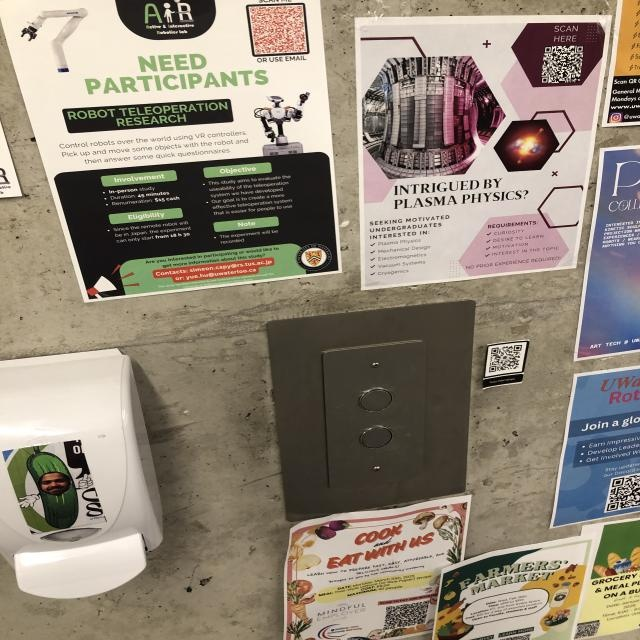

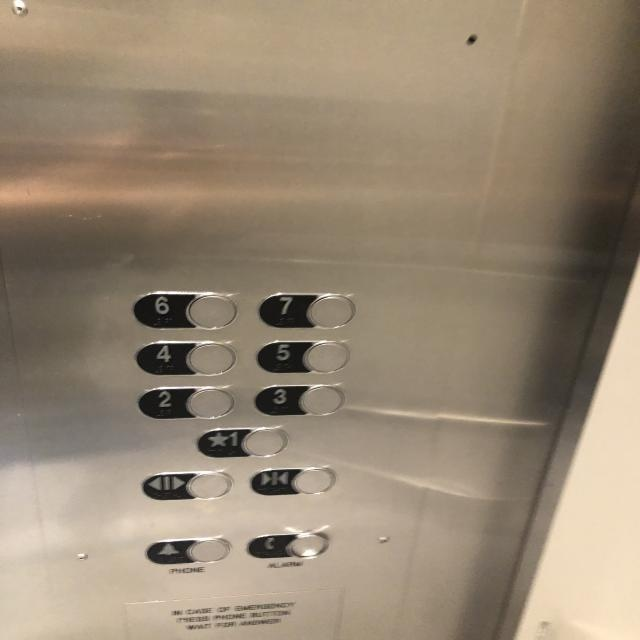

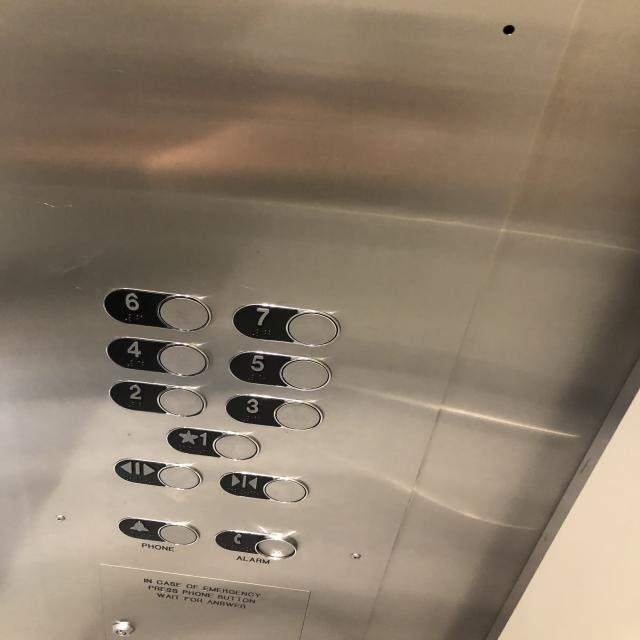

In [20]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:]:
      display(Image(filename=image_path, height=600))
      print("\n")

## Save & Deploy model

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload and your model weights to Roboflow Deploy for autolabeling, autoscaling inference, and storage for later use.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) supports uploading YOLOv8 weights.

Run this cell to save your model weights:

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8-seg", model_path=f"{HOME}/runs/segment/train/")

Dependency ultralytics==8.0.196 is required but found version=8.2.103, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/model-examples/car-parts-instance-segmentation/3
Share your model with the world at: https://universe.roboflow.com/model-examples/car-parts-instance-segmentation/model/3


Follow the links above to check if the upload succeeded. It may take a couple of minutes until the model is visible to the `roboflow` SDK.

In [ ]:
# Run inference on your model on a persistant, auto-scaling, cloud API

# Load model
model = project.version(dataset.version).model
assert model, "Model deployment is still loading"

# Choose a random test image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image).json()
pred

running inference on 0374638_as-2885603_jpg.rf.6c1803fe031371708c4c54ef436e6dc2.jpg


{'predictions': [{'x': 527.5,
   'y': 404.0,
   'width': 521.0,
   'height': 338.0,
   'confidence': 0.9511378407478333,
   'class': 'Rearbumper',
   'points': [{'x': 346.25, 'y': 236.25},
    {'x': 343.75, 'y': 238.125},
    {'x': 343.75, 'y': 239.0625},
    {'x': 341.25, 'y': 240.9375},
    {'x': 341.25, 'y': 241.875},
    {'x': 340.0, 'y': 242.8125},
    {'x': 340.0, 'y': 244.6875},
    {'x': 338.75, 'y': 245.625},
    {'x': 338.75, 'y': 246.5625},
    {'x': 336.25, 'y': 248.4375},
    {'x': 336.25, 'y': 249.375},
    {'x': 335.0, 'y': 250.3125},
    {'x': 335.0, 'y': 253.125},
    {'x': 333.75, 'y': 254.0625},
    {'x': 333.75, 'y': 255.0},
    {'x': 331.25, 'y': 256.875},
    {'x': 331.25, 'y': 257.8125},
    {'x': 330.0, 'y': 258.75},
    {'x': 330.0, 'y': 262.5},
    {'x': 328.75, 'y': 263.4375},
    {'x': 328.75, 'y': 264.375},
    {'x': 326.25, 'y': 266.25},
    {'x': 326.25, 'y': 267.1875},
    {'x': 325.0, 'y': 268.125},
    {'x': 325.0, 'y': 271.875},
    {'x': 321.25, 'y':

# Deploy Your Model to the Edge

![Roboflow Inference banner](https://blog.roboflow.com/content/images/2023/08/banner.png)

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_thresh,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv8 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv8. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.